In [1]:
Sys.setlocale(category = "LC_ALL", locale = "en_US.UTF-8")


[1] "en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/C"

# Dependencies

In [2]:
pacman::p_load(dplyr, ggplot2, ggbeeswarm, ggpubr, ggsignif, cowplot, ggh4x, ggrepel, ComplexHeatmap, lsmeans, tidyr)

# Functions

In [3]:
source("/Users/anabbi/git/ped_CapTCRseq/R/functions/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/functions/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/functions/Misc_functions.R")

In [4]:
scaleFUN <- function(x) sprintf("%.1f", x)

# Paths

In [5]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [6]:
# h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Files

In [7]:
meta_div <- readr::read_rds(paste0(datapath, "capTCRseq/meta_div_goodsamples.rds"))

In [8]:
soc_good <- readr::read_rds(paste0(datapath,"soc_good_with_baseregimen.rds"))

In [11]:
soc_good[ soc_good$Patient %in% c("CHP_415"),]

Patient ID,Diagnosis,Cycle 1 Type,Cycle 1 Drugs,Cycle 1 Duration (days),Cycle 1 Steroids,Cycle 2 Type,Cycle 2 Drugs,Cycle 2 Duration (days),Cycle 2 Steroids,...,base_regimen_cycle2,base_regimen_cycle3,base_regimen_cycle4,base_regimen_cycle5,cycle1exist,cycle2exist,cycle3exist,cycle4exist,cycle5exist,Patient
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
415,HD,Induction I,"Vincristine, Prednisone, Doxorubicin, Bleomyocin, Etoposide, Cyclophosphamide",21,Yes,Induction II,"Vincristine, Prednisone, Doxorubicin, Bleomyocin, Etoposide, Cyclophosphamide",21,Yes,...,Vincristine/Cyclophosphamide,No therapy,No therapy,No therapy,Yes,Yes,NA,NA,NA,CHP_415


In [12]:
soc_good_long <- soc_good %>%
  pivot_longer(
    cols = starts_with("base_regimen_"),
    names_to = "cycle",
    values_to = "regimen",
    names_prefix = "base_regimen_"
  ) %>%
  select(Patient, cycle, regimen)

head(soc_good_long)

Patient,cycle,regimen
<chr>,<chr>,<fct>
CHP_319,cycle1,Vincristine
CHP_319,cycle2,Vincristine/Cyclophosphamide
CHP_319,cycle3,Vincristine/Methotrexate
CHP_319,cycle4,Vincristine/Cyclophosphamide
CHP_319,cycle5,Vincristine/Methotrexate
CHP_323,cycle1,Vincristine


In [13]:
soc_good_long[ soc_good_long$Patient == "CHP_350",]

Patient,cycle,regimen
<chr>,<chr>,<fct>
CHP_350,cycle1,Vincristine
CHP_350,cycle2,Vincristine
CHP_350,cycle3,No therapy
CHP_350,cycle4,No therapy
CHP_350,cycle5,No therapy


In [14]:
# Join soc_good_long to meta_div
# First, create a mapping between cycle formats (X05 -> cycle5)
meta_div$cycle_mapped <- paste0("cycle", gsub("X0?", "", meta_div$cycle))

# Join the datasets
meta_div <- meta_div %>%
  left_join(soc_good_long, by = c("Patient" = "Patient", "cycle_mapped" = "cycle"))

# Clean up the temporary column
 meta_div$cycle_mapped <- NULL


In [15]:
# Create exposed_regimen column, for each patient, if cycle is X01, then it is baseline, otherwise it is the previous cycle's regimen
## Use the soc_good dataframe to get the regimen for the previous cycle
## First, create a mapping between cycle formats (X05 -> cycle5)
## be explicit, eg get regimen of X04 for exponsed_regimen of X05
# Create exposed_regimen column
meta_div$exposed_regimen <- NA

# For each sample, determine the exposed regimen
for (i in 1:nrow(meta_div)) {
  current_patient <- meta_div$Patient[i]
  current_cycle <- meta_div$cycle[i]
  
  # If it's X01 (first cycle), exposed_regimen is NA (baseline)
  if (current_cycle == "X01") {
    meta_div$exposed_regimen[i] <- "baseline"
  } else {
    # Extract cycle number and get previous cycle
    cycle_num <- as.numeric(gsub("X0?", "", current_cycle))
    prev_cycle_num <- cycle_num - 1
    
    # Format previous cycle (e.g., 4 -> "cycle4")
    prev_cycle_col <- paste0("cycle", prev_cycle_num)
    
    # Get the base regimen for the previous cycle from soc_good
    prev_regimen <- as.character(soc_good[soc_good$Patient == current_patient, paste0("base_regimen_", prev_cycle_col), drop = T])
    
    if (length(prev_regimen) > 0 && !is.na(prev_regimen)) {
      meta_div$exposed_regimen[i] <- prev_regimen
    }
  }
}



In [16]:
head(meta_div[ meta_div$Patient == "CHP_350",])

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,SE_Simpson,basename,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen,exposed_regimen
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<chr>
40,CHP_350_01,CHP_350,X01,2.7,1615.44,1,HB,2.7,1338,18,...,3.9840934,CHP_350-01-PBMC-DNA,batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_350-01-PBMC-DNA.txt,PBMC,CHP,2.0781867,CHP_350_01_PBMC,Flow cytometry & capTCR-seq,Vincristine,baseline
41,CHP_350_02,CHP_350,X02,39.5,0.00,1,HB,39.5,2368,26,...,5.4315532,CHP_350-02-PBMC-DNA,batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_350-02-PBMC-DNA.txt,PBMC,CHP,2.3185028,CHP_350_02_PBMC,Flow cytometry & capTCR-seq,Vincristine,Vincristine
42,CHP_350_03,CHP_350,X03,10.1,0.00,1,HB,10.1,2394,64,...,3.7115525,CHP_350-03-PBMC-DNA,batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_350-03-PBMC-DNA.txt,PBMC,CHP,2.2029746,CHP_350_03_PBMC,Flow cytometry & capTCR-seq,No therapy,Vincristine
43,CHP_350_04,CHP_350,X04,2.6,0.00,1,HB,2.6,3067,31,...,2.6728608,CHP_350-04-PBMC-DNA,batch_reseq_24Feb2020/mixcr/clones/CLONES_TRBCHP_350-04-PBMC-DNA.txt,PBMC,CHP,1.9081090,CHP_350_04_PBMC,Flow cytometry & capTCR-seq,No therapy,No therapy
44,CHP_350_05,CHP_350,X05,1.3,0.00,1,HB,1.3,483,6,...,0.8966621,CHP_350-05-PBMC-DNA,batch3_19Aug2019/mixcr/clones/CLONES_TRBCHP_350-05-PBMC-DNA.txt,PBMC,CHP,1.6446304,CHP_350_05_PBMC,Flow cytometry & capTCR-seq,No therapy,No therapy
250,CHP_350_02,CHP_350,X02,39.5,0.00,1,HB,39.5,2368,26,...,0.0550814,CHP_350-02_cfDNA,remaining_batch_4_cfDNA_15April2021/mixcr/clones/CLONES_TRBCHP_350-02_cfDNA.txt,cfDNA,CHP,0.8449792,CHP_350_02_cfDNA,capTCR-seq,Vincristine,Vincristine


# Main

Separate PBMC and cfDNA

In [17]:
table(meta_div$cancergroup)


           Leukemia            Lymphoma        Solid tumors T-cell malignancies 
                262                  94                 193                  30 

In [18]:
meta_div <- meta_div[ meta_div$cancergroup != "T-cell malignancies", ]

In [19]:
pbmc <- meta_div[ which(meta_div$sampletype == "PBMC"),]
cfdna <- meta_div[ which(meta_div$sampletype == "cfDNA"),]

### Change relative to with baseline

In [20]:
pbmc <- meta_div[ which(meta_div$sampletype == "PBMC"),]
pbmc <- pbmc[ !is.na(pbmc$TRB),]

In [21]:
pbmc$log10shann_scaled <- scale(pbmc$log10shann)

In [22]:
diff_log10shann <- calculate_delta.fx(pbmc, "cycle", "log10shann_scaled")
diff_log10shann <- diff_log10shann[!is.na(diff_log10shann$Difference), ]

In [23]:
head(diff_log10shann)

sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,file,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen,exposed_regimen,log10shann_scaled,Difference
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<chr>,"<dbl[,1]>","<dbl[,1]>"
CHP_347_01,CHP_347,X01,0.8,126.72,13,ALL,0.8,1701,1,...,batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_347-01-PBMC-DNA.txt,PBMC,CHP,2.029022,CHP_347_01_PBMC,Flow cytometry & capTCR-seq,Vincristine,baseline,0.1763328,0.0000000
CHP_347_02,CHP_347,X02,6.4,1038.59,13,ALL,6.4,927,15,...,batch4_19Aug2019/mixcr/clones/CLONES_TRBCHP_347-02-PBMC-DNA.txt,PBMC,CHP,2.447600,CHP_347_02_PBMC,Flow cytometry & capTCR-seq,Vincristine/Cyclophosphamide,Vincristine,0.8825973,0.7062645
CHP_347_03,CHP_347,X03,37.6,768.80,13,ALL,37.6,2379,27,...,batch7_25Oct2019/mixcr/clones/CLONES_TRBCHP_347-03-PBMC-DNA.txt,PBMC,CHP,1.841164,CHP_347_03_PBMC,Flow cytometry & capTCR-seq,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,-0.1406400,-0.3169728
CHP_347_04,CHP_347,X04,0.8,1542.25,13,ALL,0.8,745,14,...,batch6a_5Nov2019/mixcr/clones/CLONES_TRBCHP_347-04-PBMC-DNA.txt,PBMC,CHP,1.847981,CHP_347_04_PBMC,Flow cytometry & capTCR-seq,Vincristine/Cyclophosphamide,Vincristine/Methotrexate,-0.1291380,-0.3054708
CHP_347_05,CHP_347,X05,2.6,1278.87,13,ALL,2.6,2175,7,...,batch8_14Jan2020/mixcr/clones/CLONES_TRBCHP_347-05-PBMC-DNA.txt,PBMC,CHP,2.006777,CHP_347_05_PBMC,Flow cytometry & capTCR-seq,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,0.1387993,-0.0375335
CHP_348_01,CHP_348,X01,11.5,50.96,18,OS,11.5,1125,28,...,batch2_Aug62019/mixcr/clones/CLONES_TRBCHP_348-01-PBMC-DNA.txt,PBMC,CHP,1.844739,CHP_348_01_PBMC,Flow cytometry & capTCR-seq,Methotrexate,baseline,-0.1346076,0.0000000


In [24]:
cfdna$log10shann_scaled <- scale(cfdna$log10shann)

In [25]:
diff_log10shann_cfdna <- calculate_delta.fx(cfdna, "cycle", "log10shann_scaled")
diff_log10shann_cfdna <- diff_log10shann_cfdna[ !is.na(diff_log10shann_cfdna$Difference),]

In [26]:
pbmc1 <- meta_div[ meta_div$sampletype == "PBMC" & !is.na(meta_div$CD3),]
pbmc1 <- pbmc1[ pbmc1$CD3 > 0,]

In [27]:
mycells <- c("`Naïve%`", "`SCM%`", "`CM%`", "`EM%`", "`TE%`", "`PD1%`", "`LAG3%`", "`TIM3%`")

In [28]:
for (i in 1:length(mycells)) {
    pbmc1$grp <- gsub("`", "", mycells[i])
    mycol <- paste0("Diff_", gsub("%", "", pbmc1$grp[1]))
    myvar <- paste0("scaled_", gsub("%", "", pbmc1$grp[1]))
    pbmc1[[myvar]] <- NA
    pbmc1[[myvar]] <- scale(pbmc1[[pbmc1$grp[1]]])
    mydiff <- calculate_delta.fx(pbmc1, "cycle", myvar)
    # print(summary(mydiff$Difference))
    pbmc1[[mycol]] <- mydiff$Difference[match(pbmc1$sample_id, mydiff$sample_id)]
}

In [29]:
# pivot_longer
pbmc1_long <- pbmc1 %>%
    select(
        sample_id, Patient, cycle, cancergroup,Disease_type, Age, regimen, exposed_regimen,
         Relapse, Diff_Naïve, Diff_SCM, Diff_CM, Diff_EM, Diff_TE,
        Diff_PD1, Diff_LAG3, Diff_TIM3
    ) %>%
    tidyr::pivot_longer(cols = starts_with("Diff_"), names_to = "marker", values_to = "Diff")


In [30]:
pbmc1_long <- pbmc1_long[ !is.na(pbmc1_long$Diff),]

In [31]:
summary(pbmc1$Diff_LAG3[ pbmc1$cancergroup == "Solid tumors" & pbmc1$cycle == "X04"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
-0.8101  0.2590  0.9080  1.1343  1.3702  3.7911       4 

In [32]:
summary(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Lymphoma" &
    diff_log10shann_cfdna$cycle == "X05"])


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-3.3201 -1.9091 -1.1927 -1.3345 -0.4958  0.2452 

In [33]:
pbmc1_long$marker <- gsub("Diff_", "", pbmc1_long$marker)
pbmc1_long$marker <- paste0(pbmc1_long$marker, "%")

In [34]:
pbmc1_long_cells <- pbmc1_long[ pbmc1_long$marker %in% c("Naïve%", "SCM%", "CM%", "EM%", "TE%"), ]
pbmc1_long_ic <- pbmc1_long[ pbmc1_long$marker %in% c("PD1%", "LAG3%", "TIM3%"), ]

### Exploratory by cancer type

#### Leu

In [35]:
diff_log10shann$grp <- "TCR Diversity"
diff_log10shann_cfdna$grp <- "cfTCR Diversity"

In [36]:
colpal <- c("Vincristine" = "#E41A1C", 
           "Methotrexate" = "#377EB8",
           "Cyclophosphamide" = "#4DAF4A",
           "Vincristine/Methotrexate" = "#984EA3",
           "Vincristine/Cyclophosphamide" = "#fa9734",
           "Vincristine/Methotrexate/Cyclophosphamide" = "#f781bf",
           "No therapy" = "grey",
           "Others" = "#6c6c6c")


In [37]:
delta_basespiderplot.fx <- function(df_diff, var1, clrby, colpal) {
    # Create segments data for coloring lines by regimen
    segments_data <- df_diff %>%
        arrange(Patient, eval(parse(text = var1))) %>%
        group_by(Patient) %>%
        mutate(
            x_start = eval(parse(text = var1)),
            y_start = Difference,
            x_end = lead(eval(parse(text = var1))),
            y_end = lead(Difference),
            segment_regimen = lead(exposed_regimen)
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p0 <- ggplot(df_diff, aes(x = eval(parse(text = var1)), y = Difference)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm"))
    return(p0)
}

In [38]:
# Ensure levels of 'exposed_regimen' in diff_log10shann match colpal order
diff_log10shann$exposed_regimen <- factor(
  diff_log10shann$exposed_regimen,
  levels = names(colpal)
)


In [39]:
p_shann_temp <- delta_basespiderplot.fx(
    diff_log10shann,
    "cycle", "exposed_regimen", colpal
)

In [40]:
pdf(paste0(plotpath, "regimenline_lgd_horizontal.pdf"), width = 15, height = 5)
grid.draw(get_legend(p_shann_temp +
guides(colour = guide_legend(title = "Regimen", nrow = 2)))) 
dev.off()

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


pdf 
  2

In [41]:
p_shann_leu <- delta_basespiderplot.fx(
    diff_log10shann[diff_log10shann$cancergroup == "Leukemia", ],
    "cycle", "exposed_regimen", colpal
)

In [42]:
p_shann_leu <- p_shann_leu + theme(legend.position = "none") +
  facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
  theme(
    plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.text.x = element_text(size = 13),
    strip.background.x = element_blank(),
    strip.placement = "outside"
  ) +
  ylab("D TCR diversity") +
  # scale_x_discrete(get_breaks("cycle"),
  #   labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
  # ) + 
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") #+
  # annotate("ribbon",
  #   x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
  #   alpha = 0.3, fill = "light grey"
  # ) +
  # scale_color_manual(labels = c("No Relapse", "Relapse"), values = c("0" = "blue", "1" = "red"))


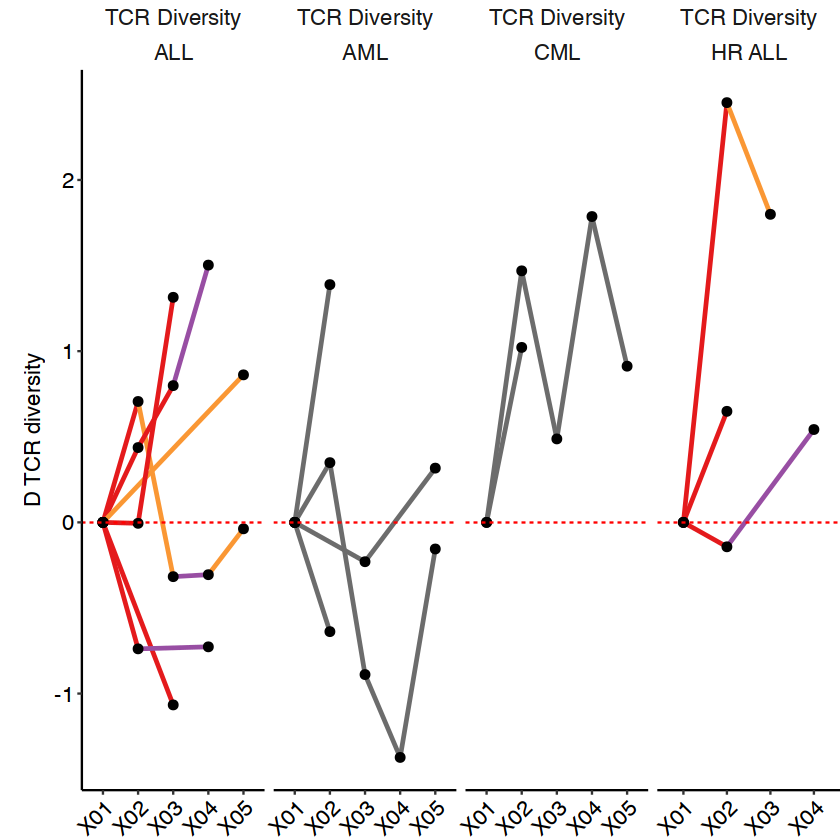

In [43]:
p_shann_leu

In [41]:
# last_timepoint <- diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Leukemia", ] %>%
#     group_by(Patient) %>%
#     filter(cycle == max(cycle))
# last_timepoint$cycleno <- as.numeric(gsub("X0", "", last_timepoint$cycle))

# p_cfshann_leu + geom_text_repel(
#     data = last_timepoint,
#     aes(label = Age),
#     hjust = "left",
#     direction = "y",
#     nudge_x = 6.5 - last_timepoint$cycleno,
#     size = 3,
#     xlim = c(4, NA),
#     segment.color = "black"
# ) + facet_wrap(~Disease_type, nrow = 1, scales = "free_x", strip.position = "top")


In [42]:
# q_10_90 <- quantile(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Leukemia" &
#     diff_log10shann_cfdna$cycle != "X01"], c(0.1, 0.9))


In [44]:
p_cfshann_leu <- delta_basespiderplot.fx(
    diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Leukemia", ],
    "cycle", "exposed_regimen", colpal
)

p_cfshann_leu <- p_cfshann_leu + theme(legend.position = "none") +
    facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 
    # annotate("ribbon",
    #     x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
    #     alpha = 0.3, fill = "light grey"
    # )


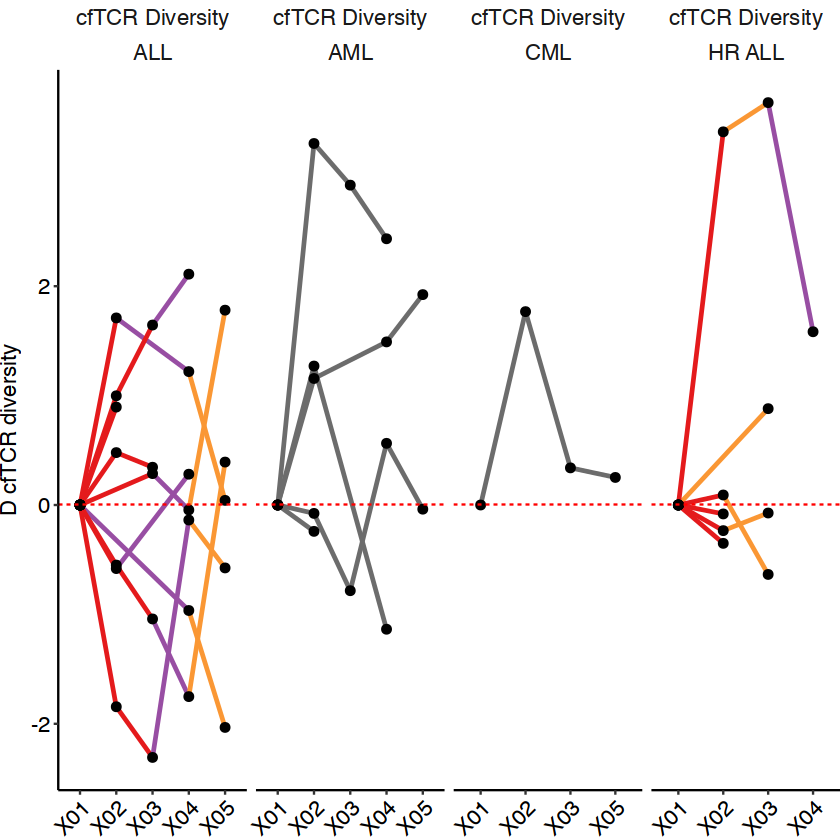

In [45]:
p_cfshann_leu

In [46]:
head(pbmc1_long_cells)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,exposed_regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>,<chr>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,Naïve%,-0.4373741
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,SCM%,0.4160531
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,CM%,0.9388408
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,EM%,0.1749391
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,TE%,-0.4073194
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,Others,Others,0,Naïve%,-0.4262616


In [47]:
pbmc1_long_cells$marker <- factor(pbmc1_long_cells$marker, levels = c("Naïve%", "SCM%", "CM%", "EM%", "TE%"))

In [48]:
cancergroup <- "Leukemia"

# mymat <- data.frame(
#     "marker" = rep(unique(pbmc1_long_cells$marker[pbmc1_long_cells$cancergroup == cancergroup]), 2),
#     "x" = NA, "q10" = NA, "q90" = NA
# )

# for (i in unique(pbmc1_long_cells$marker)) {
#     mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
#         pbmc1_long_cells$cycle != "X01" &
#         pbmc1_long_cells$marker == i], 0.1)
#     mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_cells$Diff[pbmc1_long_cells$cancergroup == cancergroup &
#         pbmc1_long_cells$cycle != "X01" &
#         pbmc1_long_cells$marker == i], 0.9)
#     mymat$x[mymat$marker == i] <- c(-Inf, Inf)
# }


In [49]:
head(pbmc1_long_cells)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,exposed_regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>,<fct>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,Naïve%,-0.4373741
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,SCM%,0.4160531
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,CM%,0.9388408
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,EM%,0.1749391
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,TE%,-0.4073194
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,Others,Others,0,Naïve%,-0.4262616


In [50]:
    segments_data <- pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Leukemia", ] %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = lead(exposed_regimen)
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_leu <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Leukemia", ], aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm")) +
facet_wrap(~marker + Disease_type, nrow = 5, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D T-cell subsets") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

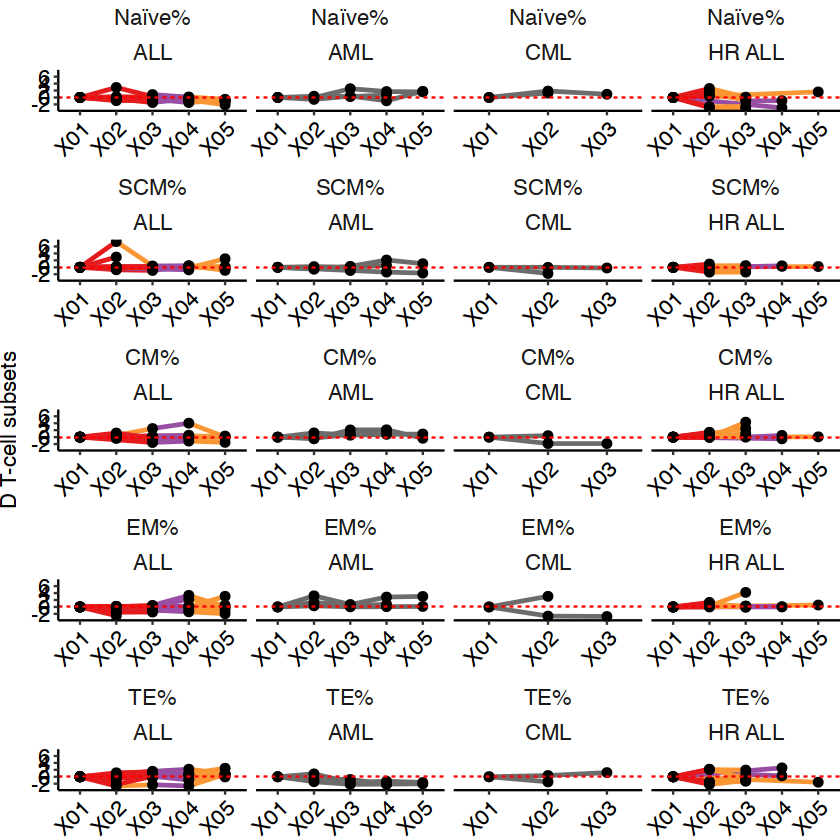

In [51]:
p_leu

In [52]:
# p_leu <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Leukemia", ], aes(x = cycle, y = Diff)) +
#     geom_point(aes(color = factor(Relapse)), cex = 2) +
#     geom_line(aes(group = Patient, color = factor(Relapse))) +
#      scale_color_manual(values = c("0" = "blue", "1" = "red")) +
#     myplot +
#     myaxis +
#     theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
#         axis.text.x = element_blank(),
#         axis.title.x = element_blank(), legend.position = "none"
#     ) +
# # geom_ribbon(data = mymat, 
# #     aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
# #   ) +
#     facet_wrap(~marker + Disease_type, nrow = 5, scales = "free_x", strip.position = "top") +
#     theme(
#         axis.title.x = element_blank(),
#         legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside"
#     ) +
#     ylab("D T-cell subsets") +
#     scale_x_discrete(get_breaks("cycle"),
#         labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
#     ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [53]:
pdf(paste0(plotpath, "p_leu_spiderplots_disease_type.pdf"), width = 10, height = 13)
cowplot::plot_grid(p_leu)
dev.off()

pdf 
  2

In [54]:
# cancergroup <- "Leukemia"

# mymat <- data.frame(
#     "marker" = rep(unique(pbmc1_long_ic$marker[pbmc1_long_ic$cancergroup == cancergroup]), 2),
#     "x" = NA, "q10" = NA, "q90" = NA
# )

# for (i in unique(pbmc1_long_ic$marker)) {
#     mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
#         pbmc1_long_ic$cycle != "X01" &
#         pbmc1_long_ic$marker == i], 0.1)
#     mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
#         pbmc1_long_ic$cycle != "X01" &
#         pbmc1_long_ic$marker == i], 0.9)
#     mymat$x[mymat$marker == i] <- c(-Inf, Inf)
# }


In [55]:
    segments_data <- pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Leukemia", ] %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = lead(exposed_regimen)
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_leu_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Leukemia", ], aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm")) +
facet_wrap(~marker + Disease_type, nrow = 3, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D Immune Checkpoint proteins") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [56]:
# p_leu_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Leukemia", ], aes(x = cycle, y = Diff)) +
#     geom_point(aes(color = factor(Relapse)), cex = 2) +
#     geom_line(aes(group = Patient, color = factor(Relapse))) +
#     scale_color_manual(values = c("0" = "blue", "1" = "red")) +
#     myplot +
#     myaxis +
#     theme(
#         plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
#         axis.text.x = element_blank(),
#         axis.title.x = element_blank(), legend.position = "none"
#     ) +
#     geom_ribbon(
#         data = mymat,
#         aes(x = x, y = NULL, ymin = q10, ymax = q90), alpha = 0.3, fill = "light grey"
#     ) +
#     facet_wrap(~ marker + Disease_type, nrow = 3, scales = "free_x", strip.position = "top") +
#     theme(
#         axis.title.x = element_blank(),
#         legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside"
#     ) +
#     ylab("D Immune Checkpoint proteins") +
#     scale_x_discrete(get_breaks("cycle"),
#         labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
#     ) +
#     geom_hline(yintercept = 0, linetype = "dashed", color = "red")


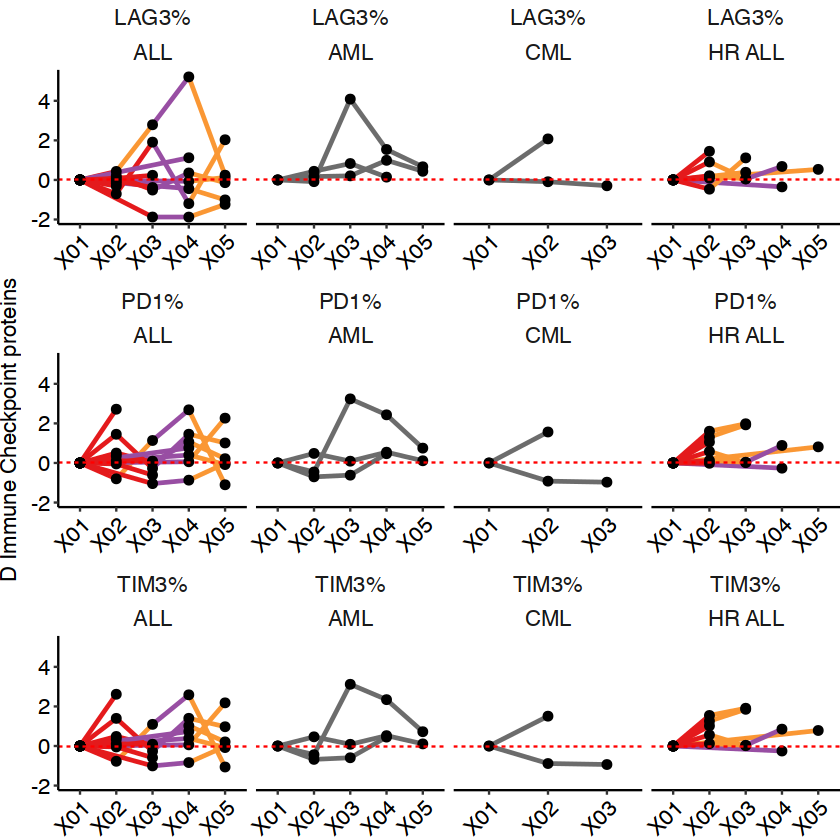

In [57]:
p_leu_ic

In [58]:
pdf(paste0(plotpath, "p_leu_ic_spiderplots_disease_type.pdf"), width = 10, height = 13)
cowplot::plot_grid(p_leu_ic)
dev.off()


pdf 
  2

#### Lym

In [59]:
# q_10_90 <- quantile(diff_log10shann$Difference[diff_log10shann$cancergroup == "Lymphoma" &
#     diff_log10shann$cycle != "X01"], c(0.1, 0.9))


In [60]:
p_shann_lym <- delta_basespiderplot.fx(
    diff_log10shann[diff_log10shann$cancergroup == "Lymphoma", ],
    "cycle", "exposed_regimen", colpal
)

In [61]:
# p_shann_lym <- delta_basespiderplot.fx(
#     diff_log10shann[diff_log10shann$cancergroup == "Lymphoma", ],
#     "cycle", "factor(Relapse)", c("0" = "blue", "1" = "red")
# ) + theme(legend.position = "none")

In [62]:
p_shann_lym <- p_shann_lym + theme(legend.position = "none") +
  facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
  theme(
    plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.text.x = element_text(size = 13),
    strip.background.x = element_blank(),
    strip.placement = "outside"
  ) +
  ylab("D TCR diversity") +
  # scale_x_discrete(get_breaks("cycle"),
  #   labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
  # ) + 
  geom_hline(yintercept = 0, linetype = "dashed", color = "red")

In [63]:
# p_shann_lym <- p_shann_lym + theme(legend.position = "none") +
#   facet_wrap(~Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
#   theme(
#     plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
#     axis.title.x = element_blank(),
#     legend.position = "none",
#     strip.text.x = element_text(size = 13),
#     strip.background.x = element_blank(),
#     strip.placement = "outside"
#   ) +
#   ylab("D TCR diversity") +
#   scale_x_discrete(get_breaks("cycle"),
#     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5") ) +
#       annotate("ribbon",
#     x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
#     alpha = 0.3, fill = "light grey"
#   ) +
#   geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

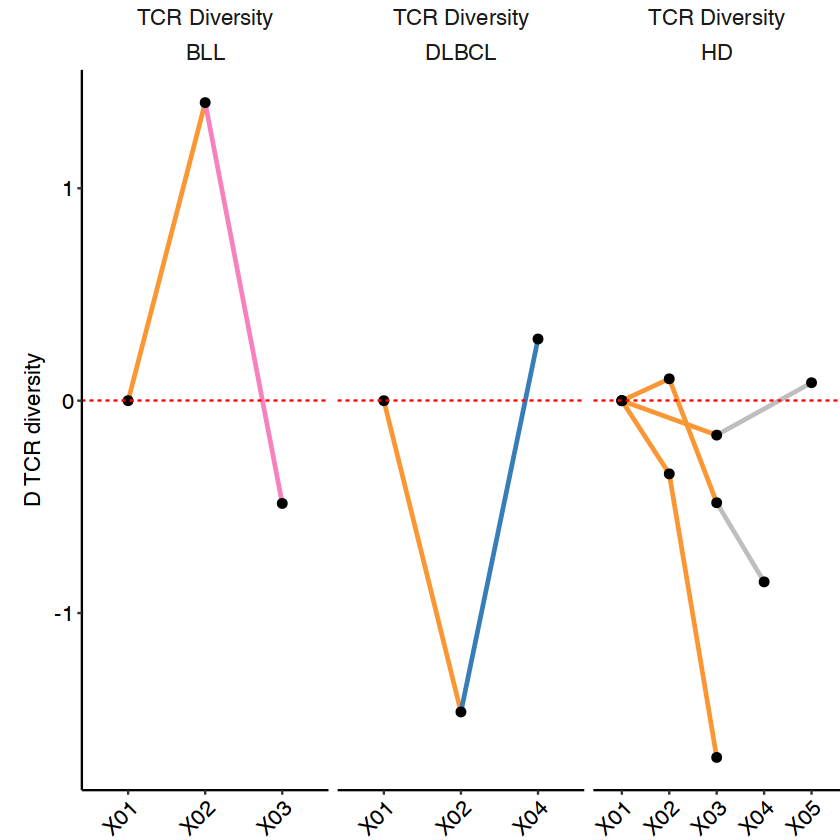

In [64]:
p_shann_lym

In [65]:
p_cfshann_lym <- delta_basespiderplot.fx(
    diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Lymphoma", ],
    "cycle", "exposed_regimen", colpal
)

p_cfshann_lym <- p_cfshann_lym + theme(legend.position = "none") +
    facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 


In [66]:
# p_cfshann_lym <- p_cfshann_lym + theme(legend.position = "none") +
#     facet_wrap(~Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
#     theme(
#         plot.margin = unit(c(0, 0, 0, 0), "cm"),
#         axis.title.x = element_blank(),
#         legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside"
#     ) +
#     ylab("D cfTCR diversity") +
#     scale_x_discrete(get_breaks("cycle"),
#         labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5") ) +
#           annotate("ribbon",
#     x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
#     alpha = 0.3, fill = "light grey"
#   ) +
#     geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

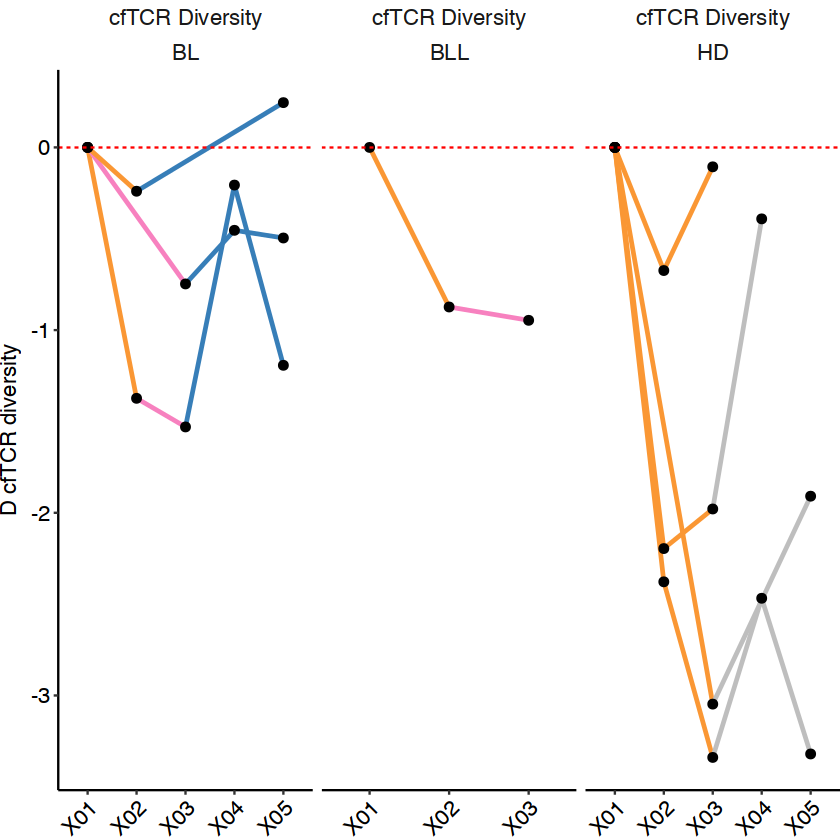

In [67]:
p_cfshann_lym

In [68]:
pdf(paste0(plotpath, "p_lym_cftcr_spiderplots_disease_type.pdf"), width = 10, height = 4)
cowplot::plot_grid(p_cfshann_lym)
dev.off()

pdf 
  2

In [69]:
    segments_data <- pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Lymphoma", ] %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = lead(exposed_regimen)
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_lym <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Lymphoma", ], aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm")) +
facet_wrap(~marker + Disease_type, nrow = 5, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
     ylab("D T-cell subsets") #+
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

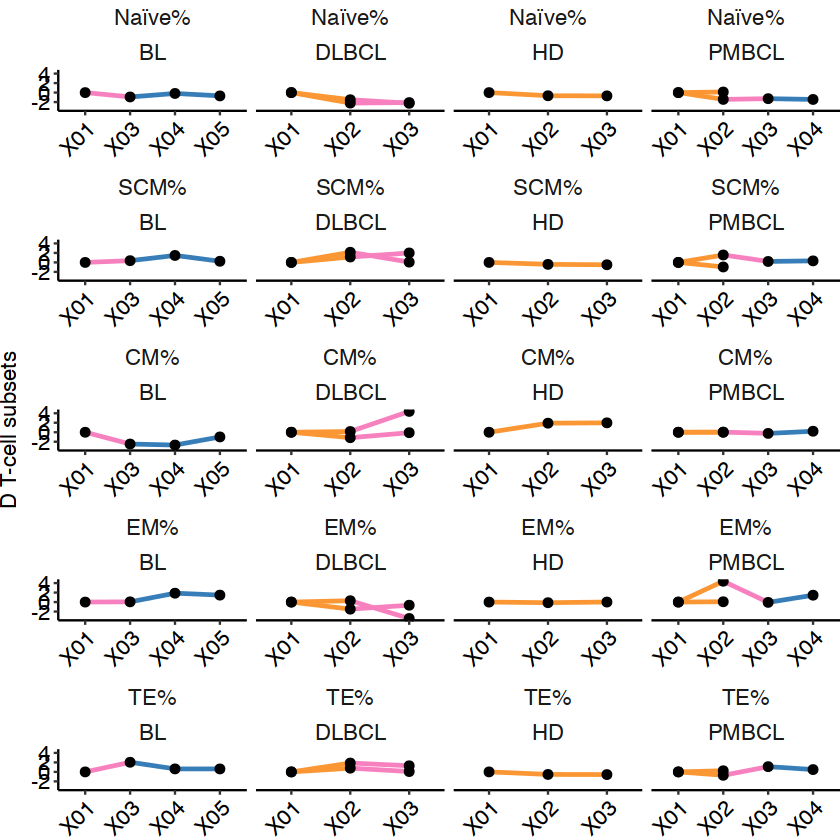

In [70]:
p_lym

In [71]:
pdf(paste0(plotpath, "p_lym_cells_spiderplots_disease_type.pdf"), width = 10, height = 13)
cowplot::plot_grid(p_lym)
dev.off()

pdf 
  2

In [72]:
# cancergroup <- "Lymphoma"

# mymat <- data.frame(
#     "marker" = rep(unique(pbmc1_long_ic$marker[pbmc1_long_ic$cancergroup == cancergroup]), 2),
#     "x" = NA, "q10" = NA, "q90" = NA
# )

# for (i in unique(pbmc1_long_ic$marker)) {
#     mymat$q10[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
#         pbmc1_long_ic$cycle != "X01" &
#         pbmc1_long_ic$marker == i], 0.1)
#     mymat$q90[mymat$marker == i] <- quantile(pbmc1_long_ic$Diff[pbmc1_long_ic$cancergroup == cancergroup &
#         pbmc1_long_ic$cycle != "X01" &
#         pbmc1_long_ic$marker == i], 0.9)
#     mymat$x[mymat$marker == i] <- c(-Inf, Inf)
# }


In [73]:
    segments_data <- pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Lymphoma", ] %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = lead(exposed_regimen)
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_lym_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Lymphoma", ], aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm")) +
facet_wrap(~marker + Disease_type, nrow = 3, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D Immune Checkpoint proteins") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

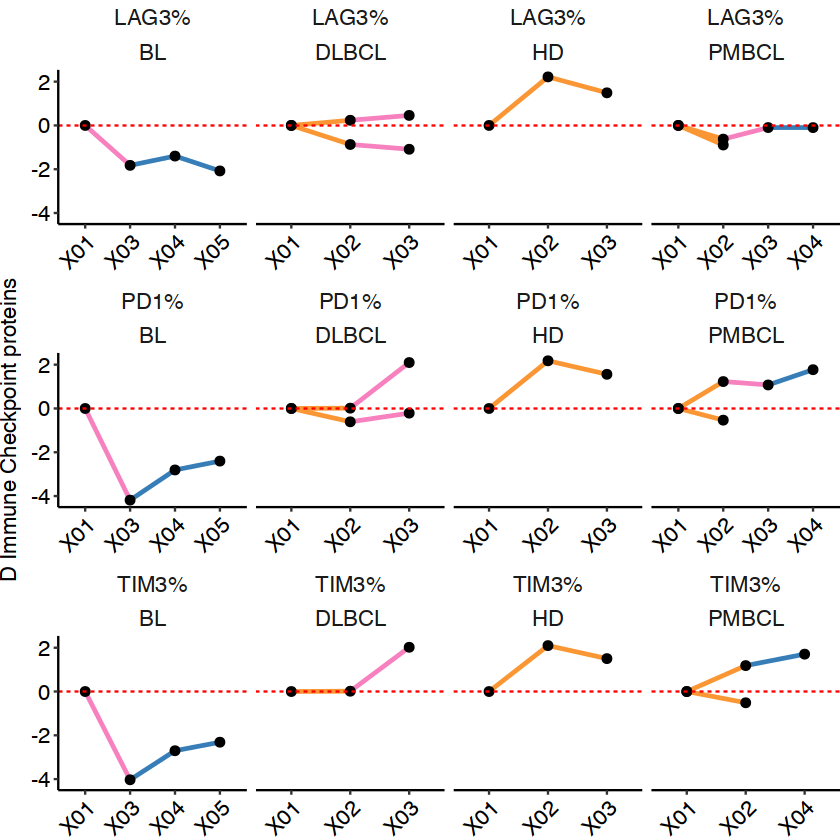

In [74]:
p_lym_ic

In [75]:
pdf(paste0(plotpath, "p_lym_ic_spiderplots_disease_type.pdf"), width = 10, height = 6)
cowplot::plot_grid(p_lym_ic)
dev.off()

pdf 
  2

#### Solid

In [76]:
p_shann_solid <- delta_basespiderplot.fx(
    diff_log10shann[diff_log10shann$cancergroup == "Solid tumors", ],
    "cycle", "exposed_regimen", colpal
)

In [77]:
p_shann_solid <- p_shann_solid + theme(legend.position = "none") +
  facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
  theme(
    plot.margin = unit(c(0, 0, 0, 0.5), "cm"),
    axis.title.x = element_blank(),
    legend.position = "none",
    strip.text.x = element_text(size = 13),
    strip.background.x = element_blank(),
    strip.placement = "outside"
  ) +
  ylab("D TCR diversity") +
  # scale_x_discrete(get_breaks("cycle"),
  #   labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
  # ) + 
  geom_hline(yintercept = 0, linetype = "dashed", color = "red")

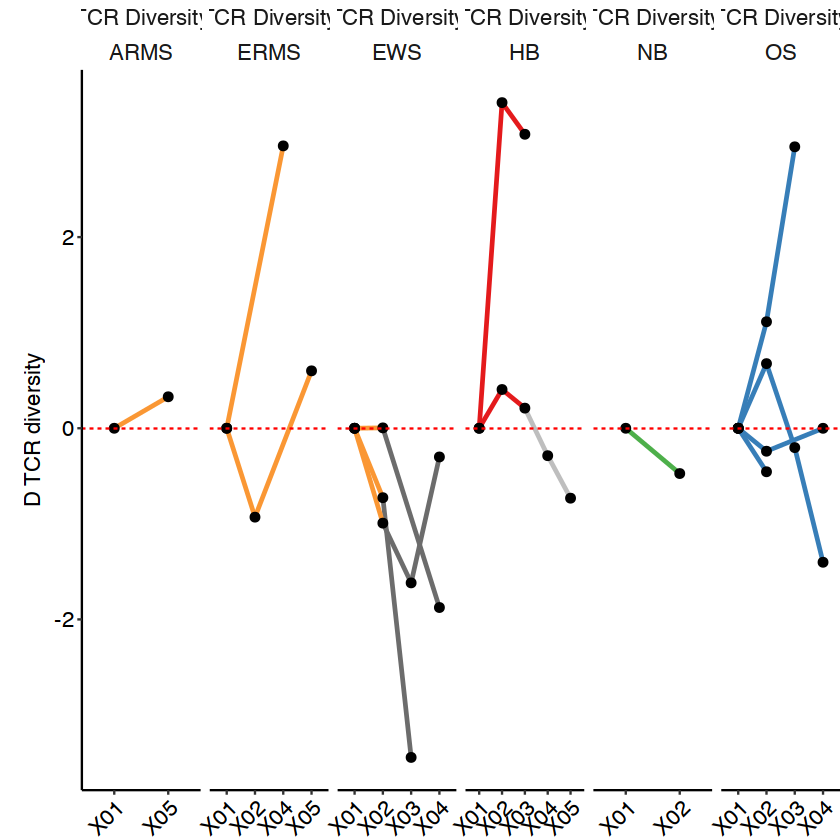

In [78]:
p_shann_solid

In [79]:
# q_10_90 <- quantile(diff_log10shann_cfdna$Difference[diff_log10shann_cfdna$cancergroup == "Solid tumors" &
#     diff_log10shann_cfdna$cycle != "X01"], c(0.1, 0.9))


In [80]:
p_cfshann_solid <- delta_basespiderplot.fx(
    diff_log10shann_cfdna[diff_log10shann_cfdna$cancergroup == "Solid tumors", ],
    "cycle", "exposed_regimen", colpal
)

p_cfshann_solid <- p_cfshann_solid + theme(legend.position = "none") +
    facet_wrap(~ grp + Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 


In [81]:
# p_cfshann_solid <- p_cfshann_solid + theme(legend.position = "none") +
#     facet_wrap(~Disease_type, nrow = 1, scales = "free_x", strip.position = "top") +
#     theme(plot.margin = unit(c(0, 0, 0, 0), "cm"),
#         axis.title.x = element_blank(),
#         legend.position = "none",
#         strip.text.x = element_text(size = 13),
#         strip.background.x = element_blank(),
#         strip.placement = "outside"
#     ) +
#     ylab("D cfTCR diversity") +
#     scale_x_discrete(get_breaks("cycle"),
#         labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
#     ) + 
#       annotate("ribbon",
#     x = c(-Inf, Inf), ymin = q_10_90[1], ymax = q_10_90[2],
#     alpha = 0.3, fill = "light grey"
#   ) +
#   geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

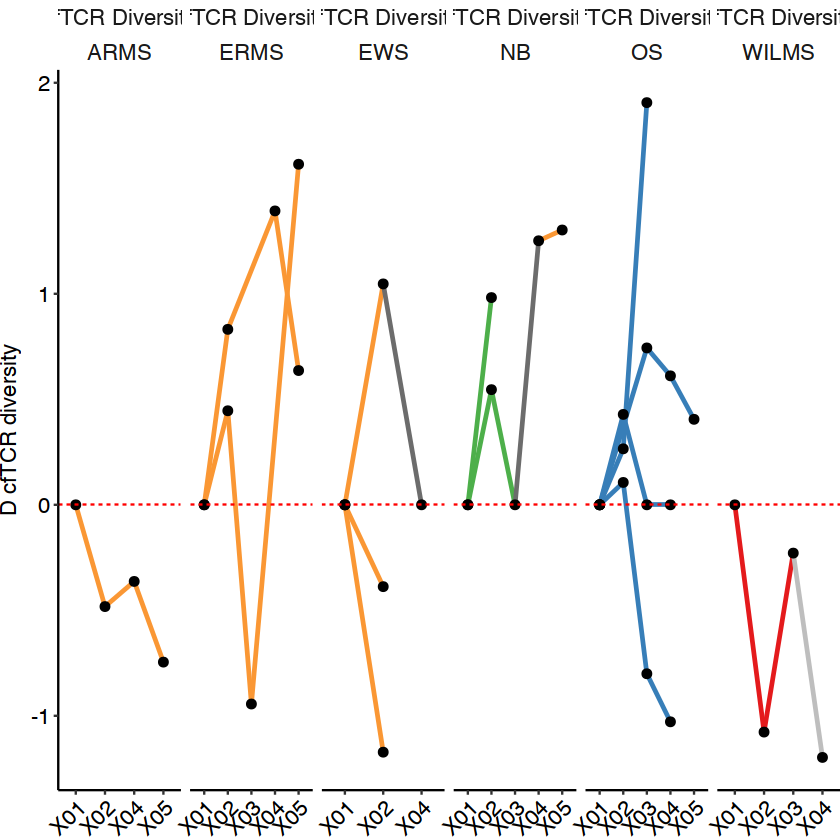

In [82]:
p_cfshann_solid

In [83]:
    segments_data <- pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Solid tumors", ] %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = lead(exposed_regimen)
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_solid <- ggplot(pbmc1_long_cells[pbmc1_long_cells$cancergroup == "Solid tumors", ], aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm")) +
facet_wrap(~marker + Disease_type, nrow = 5, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D T-cell subsets") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

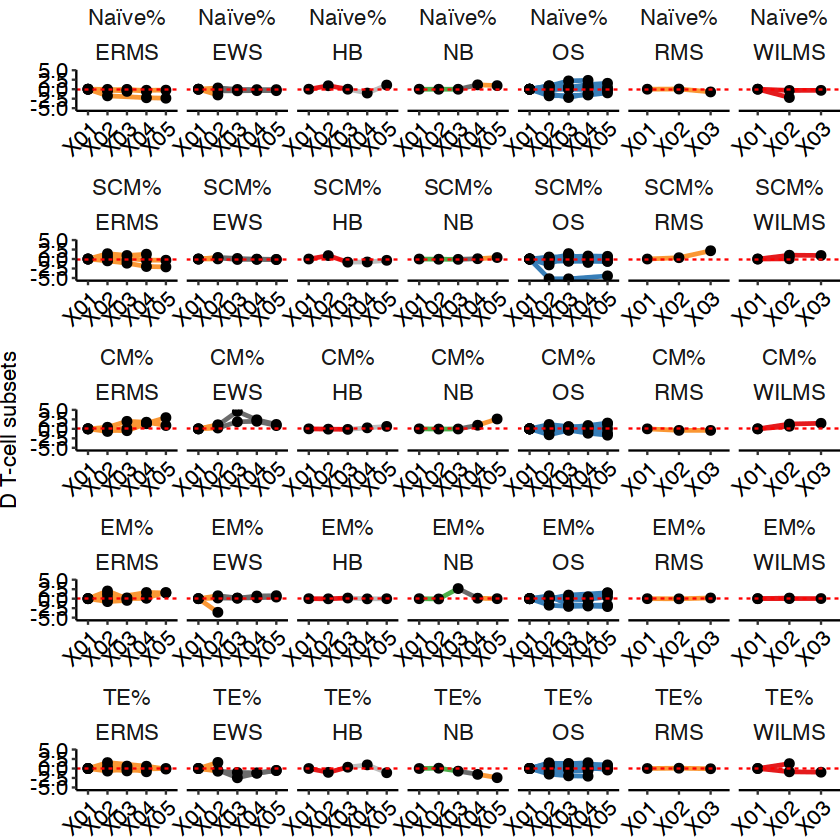

In [84]:
p_solid

In [85]:
pdf(paste0(plotpath, "p_solid_cells_spiderplots_disease_type.pdf"), width = 10, height = 13)
cowplot::plot_grid(p_solid)
dev.off()

pdf 
  2

In [86]:
    segments_data <- pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Solid tumors", ] %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = lead(exposed_regimen)
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_solid_ic <- ggplot(pbmc1_long_ic[pbmc1_long_ic$cancergroup == "Solid tumors", ], aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1), 
            axis.title.x = element_blank(), plot.margin = unit(c(0, 
                0, 0, 0), "cm")) +
facet_wrap(~marker + Disease_type, nrow = 3, scales = "free_x", strip.position = "top") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D Immune Checkpoint proteins") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) + 
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") 

In [87]:
pdf(paste0(plotpath, "p_solid_ic_spiderplots_disease_type.pdf"), width = 10, height = 8)
cowplot::plot_grid(p_solid_ic)
dev.off()


pdf 
  2

## Specific observations

Leu

In [88]:
head(pbmc1_long_cells)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,exposed_regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>,<fct>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,Naïve%,-0.4373741
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,SCM%,0.4160531
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,CM%,0.9388408
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,EM%,0.1749391
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,TE%,-0.4073194
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,Others,Others,0,Naïve%,-0.4262616


In [89]:
pbmc1_long_cells$marker <- as.character(pbmc1_long_cells$marker)

In [90]:
tmp1 <- pbmc1_long_cells[pbmc1_long_cells$Disease_type %in% c("ALL", "HR ALL") &
    pbmc1_long_cells$marker %in% c("Naïve%", "CM%"), ]

In [91]:
tmp1$marker <- factor(tmp1$marker, levels = c("Naïve%", "CM%"))

In [92]:
temp <- tmp1[ tmp1$Disease_type == "ALL" & tmp1$marker == "Naïve%", ]
temp[ temp$cycle == "X02",]
summary(temp$Diff[temp$cycle == "X05"])
summary(temp$Diff[temp$cycle == "X04"])

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,exposed_regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>,<fct>,<dbl>
CHP_347_02,CHP_347,X02,Leukemia,ALL,13,Vincristine/Cyclophosphamide,Vincristine,0,Naïve%,-0.5745485
CHP_420_02,CHP_420,X02,Leukemia,ALL,2,Vincristine,Vincristine,0,Naïve%,0.2105147
CHP_421_02,CHP_421,X02,Leukemia,ALL,8,Vincristine,Vincristine,0,Naïve%,-0.9190780
CHP_424_02,CHP_424,X02,Leukemia,ALL,1,Vincristine/Cyclophosphamide,Vincristine,0,Naïve%,-0.1103215
CHP_428_02,CHP_428,X02,Leukemia,ALL,3,Vincristine,Vincristine,0,Naïve%,-0.1079682
CHP_392_02,CHP_392,X02,Leukemia,ALL,8,Vincristine,Vincristine,0,Naïve%,-0.6964738
CHP_397_02,CHP_397,X02,Leukemia,ALL,2,Vincristine,Vincristine,0,Naïve%,2.8828062
CHP_398_02,CHP_398,X02,Leukemia,ALL,6,Vincristine,Vincristine,0,Naïve%,-0.4230203


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.1268 -1.1615 -1.0077 -1.1110 -0.8443 -0.5214 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1.4623 -0.8970 -0.7148 -0.5867 -0.1319  0.1281 

In [93]:
temp[ temp$cycle == "X05",]

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,exposed_regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>,<fct>,<dbl>
CHP_347_05,CHP_347,X05,Leukemia,ALL,13,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,0,Naïve%,-0.9048054
CHP_383_05,CHP_383,X05,Leukemia,ALL,8,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,0,Naïve%,-0.8241782
CHP_397_05,CHP_397,X05,Leukemia,ALL,2,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,0,Naïve%,-0.5214195
CHP_398_05,CHP_398,X05,Leukemia,ALL,6,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,0,Naïve%,-1.1784316
CHP_373_05,CHP_373,X05,Leukemia,ALL,2,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,0,Naïve%,-1.1105642
CHP_378_05,CHP_378,X05,Leukemia,ALL,1,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,0,Naïve%,-2.1267921


In [94]:
temp <- tmp1[ tmp1$Disease_type %in% c("ALL", "HR ALL") & tmp1$marker == "CM%", ]
summary(temp$Diff[temp$exposed_regimen == "Vincristine"])
summary(temp$Diff[temp$exposed_regimen == "Vincristine/Methotrexate"])

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.56020 -0.05835  0.19804  0.24233  0.57968  1.40934 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.14560 -0.24241  0.03701  0.39750  0.49995  4.02365 

In [95]:
temp[temp$Patient == "CHP_396",]

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,exposed_regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>,<fct>,<dbl>
CHP_396_01,CHP_396,X01,Leukemia,HR ALL,1,Vincristine,baseline,0,CM%,0.0000000
CHP_396_02,CHP_396,X02,Leukemia,HR ALL,1,Vincristine/Cyclophosphamide,Vincristine,0,CM%,1.2052016
CHP_396_03,CHP_396,X03,Leukemia,HR ALL,1,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,0,CM%,0.2207386


In [96]:
summary(temp$Diff[temp$exposed_regimen == "Vincristine/Cyclophosphamide" & temp$cycle == "X03"])

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.01113  0.43483  1.77874  1.76696  2.50414  4.32263 

In [97]:
temp[temp$Disease_type == "ALL",]

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,exposed_regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>,<fct>,<dbl>
CHP_347_01,CHP_347,X01,Leukemia,ALL,13,Vincristine,baseline,0,CM%,0.000000000
CHP_347_02,CHP_347,X02,Leukemia,ALL,13,Vincristine/Cyclophosphamide,Vincristine,0,CM%,0.491345586
CHP_347_03,CHP_347,X03,Leukemia,ALL,13,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,0,CM%,2.480387393
CHP_347_04,CHP_347,X04,Leukemia,ALL,13,Vincristine/Cyclophosphamide,Vincristine/Methotrexate,0,CM%,4.023644519
CHP_347_05,CHP_347,X05,Leukemia,ALL,13,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,0,CM%,0.034179730
CHP_373_01,CHP_373,X01,Leukemia,ALL,2,Vincristine,baseline,0,CM%,0.000000000
CHP_378_01,CHP_378,X01,Leukemia,ALL,1,Vincristine,baseline,0,CM%,0.000000000
CHP_378_04,CHP_378,X04,Leukemia,ALL,1,Vincristine/Cyclophosphamide,Vincristine/Methotrexate,0,CM%,-0.008109604
CHP_383_03,CHP_383,X03,Leukemia,ALL,8,Vincristine/Methotrexate,Vincristine,0,CM%,-1.560203310


In [98]:
temp <- tmp1[ tmp1$Disease_type == "HR ALL" & tmp1$marker == "Naïve%", ]

In [99]:
temp[ temp$Patient == "CHP_396",]

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,exposed_regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>,<fct>,<dbl>
CHP_396_01,CHP_396,X01,Leukemia,HR ALL,1,Vincristine,baseline,0,Naïve%,0.0000000
CHP_396_02,CHP_396,X02,Leukemia,HR ALL,1,Vincristine/Cyclophosphamide,Vincristine,0,Naïve%,0.5770771
CHP_396_03,CHP_396,X03,Leukemia,HR ALL,1,Vincristine/Methotrexate,Vincristine/Cyclophosphamide,0,Naïve%,-0.2805937


In [100]:
    segments_data <- tmp1 %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = lead(exposed_regimen)
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_all_hrall_naive_cm <- ggplot(tmp1, aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    ggh4x::facet_wrap2(~ marker + Disease_type, axes = "all", remove_labels = "all") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside",
        axis.line = element_line(colour = "black")
    ) +
    ylab("D T-cell subsets") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

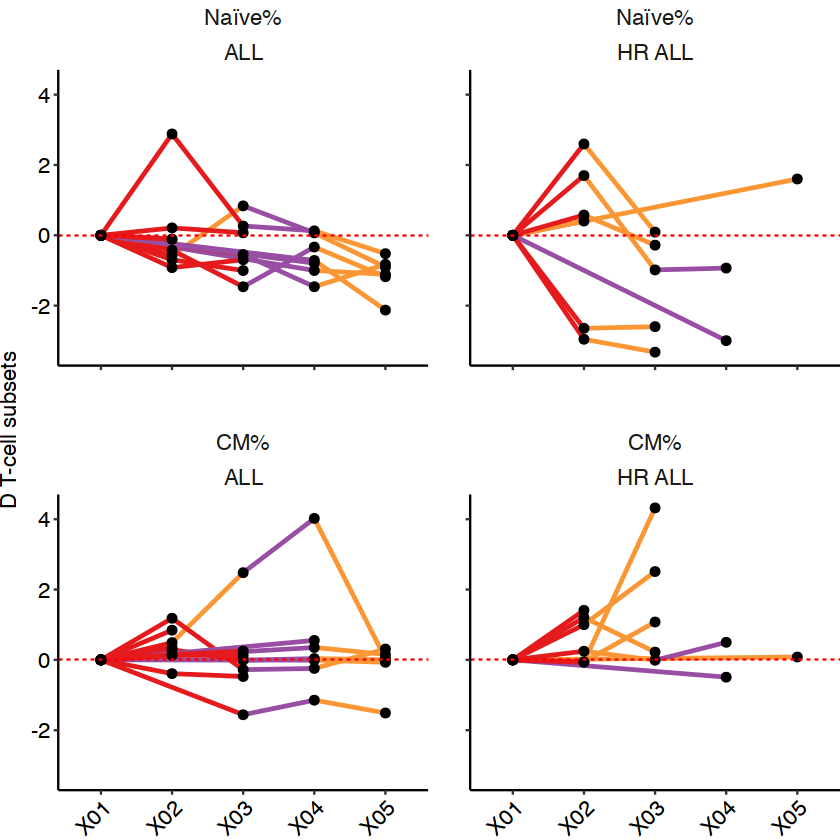

In [101]:
p_all_hrall_naive_cm

In [102]:
pdf(paste0(plotpath, "p_ALL_HRALL_Naive_CM.pdf"), width = 4, height = 6)
cowplot::plot_grid(p_all_hrall_naive_cm, labels = "A")
dev.off()

pdf 
  2

In [103]:
tmp2 <- diff_log10shann_cfdna[diff_log10shann_cfdna$Disease_type %in% c("ALL", "HR ALL", "AML"), ]

In [104]:
# temp <- tmp2[ tmp2$Disease_type == "HR ALL",]

In [105]:
# temp <- tmp2[ tmp2$Disease_type == "AML",]

In [106]:
# temp[ temp$cycle == "X02",]

In [107]:
p_cfshann_leu <- delta_basespiderplot.fx(
    tmp2,
    "cycle", "exposed_regimen", colpal
)

In [108]:
p_cfshann_leu <- p_cfshann_leu + theme(legend.position = "none") +
    ggh4x::facet_wrap2(~ grp + Disease_type, axes = "all", remove_labels = "all") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    scale_y_continuous(limits = c(-2, 4), breaks = c(-2, 0, 2, 4))



Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


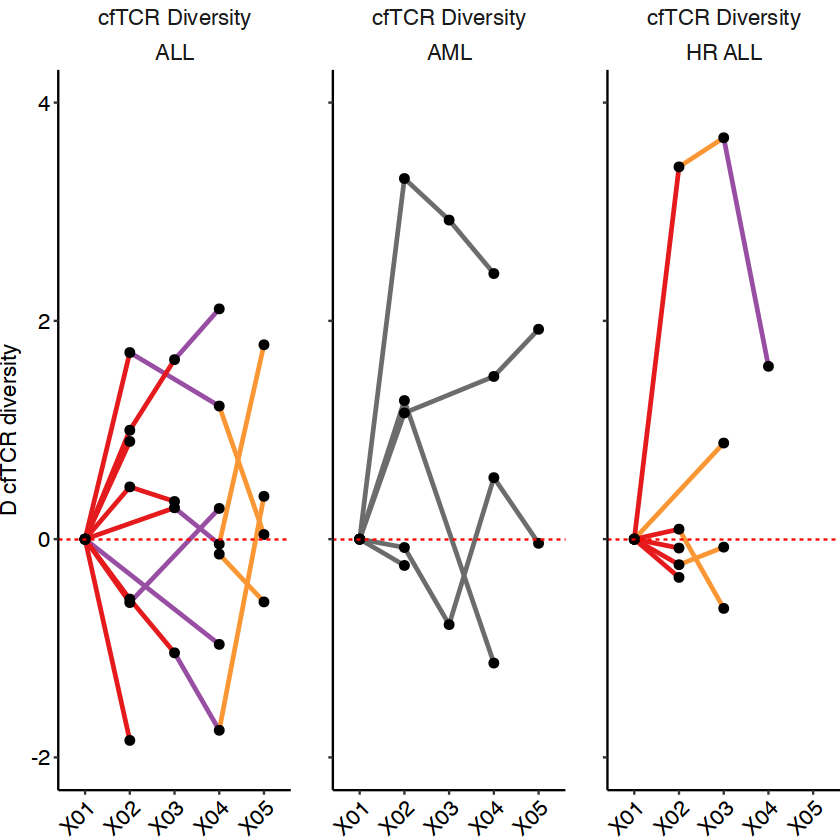

In [109]:
p_cfshann_leu

In [110]:
pdf(paste0(plotpath, "p_ALL_HRALL_AML_cfTCR.pdf"), width = 6, height = 3)
cowplot::plot_grid(p_cfshann_leu, labels = "B")
dev.off()

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


pdf 
  2

Lym

In [111]:
tmp3 <- diff_log10shann_cfdna[diff_log10shann_cfdna$Disease_type %in% c("BL", "HD"), ]

In [112]:
tmp3[ tmp3$Disease_type == "HD",]

sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,sampletype,Group,log10shann,sample_id_sampletype,assay,regimen,exposed_regimen,log10shann_scaled,Difference,grp
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<chr>,<chr>,<dbl>,<chr>,<chr>,<fct>,<chr>,"<dbl[,1]>","<dbl[,1]>",<chr>
CHP_361_01,CHP_361,X01,2.4,516.04,13,HD,2.4,2317,94,...,cfDNA,CHP,1.65081762,CHP_361_01_cfDNA,capTCR-seq,Vincristine/Cyclophosphamide,baseline,2.2694828,0.0000000,cfTCR Diversity
CHP_361_02,CHP_361,X02,1.0,0.00,13,HD,1.0,1939,59,...,cfDNA,CHP,0.60800438,CHP_361_02_cfDNA,capTCR-seq,Vincristine/Cyclophosphamide,Vincristine/Cyclophosphamide,-0.1083083,-2.3777910,cfTCR Diversity
CHP_361_03,CHP_361,X03,1.3,0.00,13,HD,1.3,2317,95,...,cfDNA,CHP,0.18645262,CHP_361_03_cfDNA,capTCR-seq,No therapy,Vincristine/Cyclophosphamide,-1.0695178,-3.3390005,cfTCR Diversity
CHP_361_04,CHP_361,X04,0.0,0.00,13,HD,0.0,NA,NA,...,cfDNA,CHP,0.56849771,CHP_361_04_cfDNA,capTCR-seq,No therapy,No therapy,-0.1983902,-2.4678729,cfTCR Diversity
CHP_361_05,CHP_361,X05,0.0,0.00,13,HD,0.0,NA,NA,...,cfDNA,CHP,0.19475626,CHP_361_05_cfDNA,capTCR-seq,No therapy,No therapy,-1.0505840,-3.3200668,cfTCR Diversity
CHP_366_01,CHP_366,X01,8.9,1113.50,14,HD,8.9,NA,243,...,cfDNA,CHP,0.96298543,CHP_366_01_cfDNA,capTCR-seq,Vincristine/Cyclophosphamide,baseline,0.7011087,0.0000000,cfTCR Diversity
CHP_366_02,CHP_366,X02,0.0,0.00,14,HD,0.0,NA,NA,...,cfDNA,CHP,0.00000000,CHP_366_02_cfDNA,capTCR-seq,Vincristine/Cyclophosphamide,Vincristine/Cyclophosphamide,-1.4946613,-2.1957701,cfTCR Diversity
CHP_366_03,CHP_366,X03,0.0,0.00,14,HD,0.0,NA,NA,...,cfDNA,CHP,0.09502418,CHP_366_03_cfDNA,capTCR-seq,No therapy,Vincristine/Cyclophosphamide,-1.2779901,-1.9790988,cfTCR Diversity
CHP_366_04,CHP_366,X04,0.0,0.00,14,HD,0.0,NA,NA,...,cfDNA,CHP,0.79146050,CHP_366_04_cfDNA,capTCR-seq,No therapy,No therapy,0.3100028,-0.3911059,cfTCR Diversity


In [113]:
p_cfshann_lym <- delta_basespiderplot.fx(
    tmp3,
    "cycle", "exposed_regimen", colpal
)

In [114]:
p_cfshann_lym <- p_cfshann_lym + theme(legend.position = "none") +
    ggh4x::facet_wrap2(~ grp + Disease_type, axes = "all", remove_labels = "all") +
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside"
    ) +
    ylab("D cfTCR diversity") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
 geom_hline(yintercept = 0, linetype = "dashed", color = "red") 



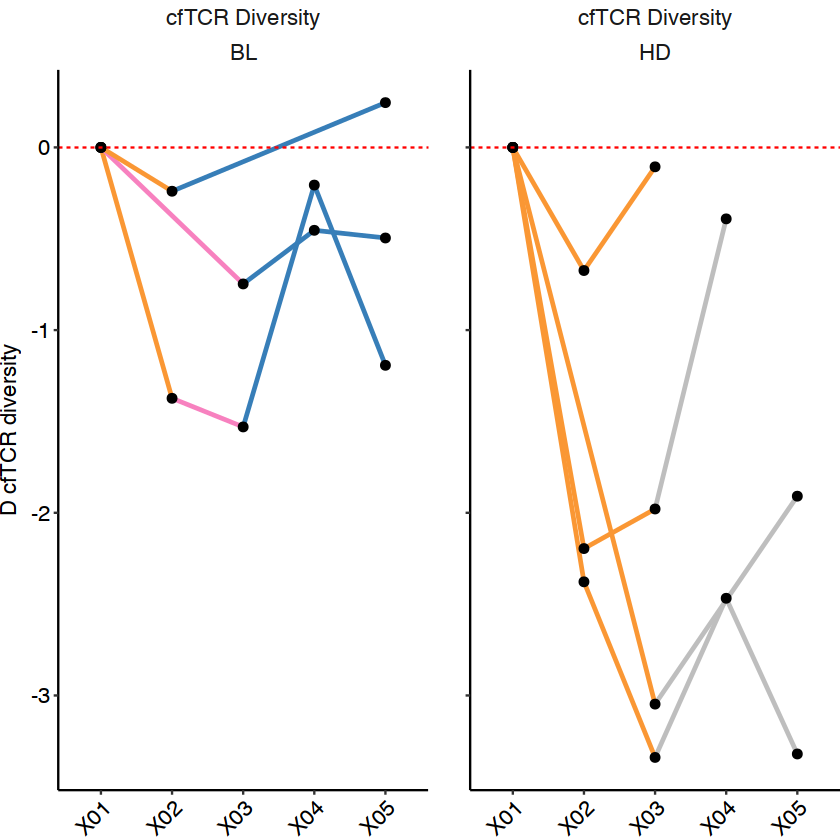

In [115]:
p_cfshann_lym

In [116]:
pdf(paste0(plotpath, "p_BL_HD_cfTCR.pdf"), width = 4, height = 3)
cowplot::plot_grid(p_cfshann_lym, labels = "C")
dev.off()

pdf 
  2

Solid

In [117]:
head(pbmc1_long_cells)

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,exposed_regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>,<chr>,<dbl>
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,Naïve%,-0.4373741
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,SCM%,0.4160531
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,CM%,0.9388408
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,EM%,0.1749391
CHP_343_02,CHP_343,X02,Solid tumors,EWS,8,Others,Vincristine/Cyclophosphamide,0,TE%,-0.4073194
CHP_343_03,CHP_343,X03,Solid tumors,EWS,8,Others,Others,0,Naïve%,-0.4262616


In [118]:
pbmc1_long_cells$marker <- as.character(pbmc1_long_cells$marker)

In [119]:
tmp4 <- pbmc1_long_cells[pbmc1_long_cells$Disease_type %in% c("ERMS", "EWS", "HB", "NB", "RMS") &
    pbmc1_long_cells$marker == "CM%", ]

In [120]:
tmp4[tmp4$Disease_type == "HB",]

sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,exposed_regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>,<chr>,<dbl>
CHP_350_01,CHP_350,X01,Solid tumors,HB,1,Vincristine,baseline,0,CM%,0.00000000
CHP_350_02,CHP_350,X02,Solid tumors,HB,1,Vincristine,Vincristine,0,CM%,-0.07770605
CHP_350_03,CHP_350,X03,Solid tumors,HB,1,No therapy,Vincristine,0,CM%,-0.13733720
CHP_350_04,CHP_350,X04,Solid tumors,HB,1,No therapy,No therapy,0,CM%,0.27074744
CHP_350_05,CHP_350,X05,Solid tumors,HB,1,No therapy,No therapy,0,CM%,0.64363614


In [121]:
    segments_data <- tmp4 %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = lead(exposed_regimen)
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_solid <- ggplot(tmp4, aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    ggh4x::facet_wrap2(~ marker + Disease_type, axes = "all", remove_labels = "all", nrow = 1) +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside",
        axis.line = element_line(colour = "black")
    ) +
    ylab("D T-cell subsets") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

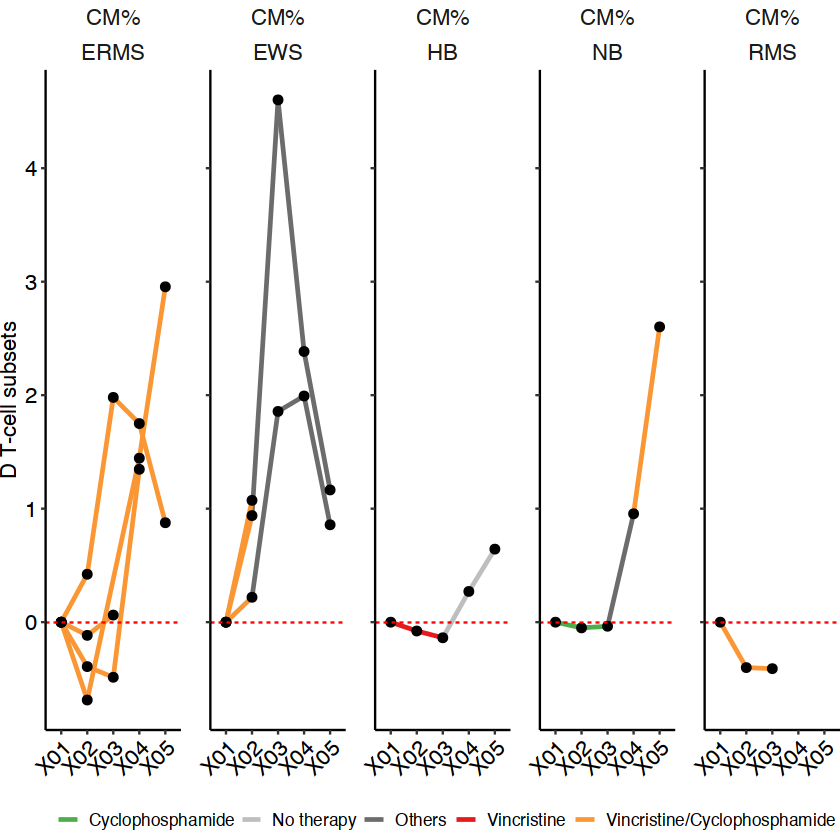

In [122]:
p_solid + theme(legend.position = "bottom")

In [123]:
pdf(paste0(plotpath, "p_HB_NB_EWS_ERMS_WIL_RMS_CM.pdf"), width = 12, height = 3)
cowplot::plot_grid(p_solid, labels = "D")
dev.off()

pdf 
  2

In [124]:
tmp6 <- pbmc1_long_ic[pbmc1_long_ic$Disease_type %in% c("ERMS", "OS", "HB") &
    pbmc1_long_ic$marker %in% c("PD1%", "LAG3%"), ]

In [125]:
mypts <- tmp6$Patient[tmp6$Disease_type == "OS"]

In [126]:
tmp6 <- tmp6[order(tmp6$Patient, tmp6$cycle),]

In [127]:
# tmp6[tmp6$Disease_type == "OS" & tmp6$marker == "PD1%",]
tmp6[tmp6$Disease_type == "OS" & tmp6$marker == "PD1%",]


sample_id,Patient,cycle,cancergroup,Disease_type,Age,regimen,exposed_regimen,Relapse,marker,Diff
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<int>,<chr>,<dbl>
CHP_330_01,CHP_330,X01,Solid tumors,OS,5,Methotrexate,baseline,0,PD1%,0.00000000
CHP_330_02,CHP_330,X02,Solid tumors,OS,5,Methotrexate,Methotrexate,0,PD1%,1.10021200
CHP_330_03,CHP_330,X03,Solid tumors,OS,5,Methotrexate,Methotrexate,0,PD1%,0.33798513
CHP_330_04,CHP_330,X04,Solid tumors,OS,5,Methotrexate,Methotrexate,0,PD1%,0.26448548
CHP_348_01,CHP_348,X01,Solid tumors,OS,18,Methotrexate,baseline,0,PD1%,0.00000000
CHP_348_02,CHP_348,X02,Solid tumors,OS,18,Methotrexate,Methotrexate,0,PD1%,1.12806290
CHP_348_03,CHP_348,X03,Solid tumors,OS,18,Methotrexate,Methotrexate,0,PD1%,0.19994694
CHP_348_05,CHP_348,X05,Solid tumors,OS,18,Methotrexate,Methotrexate,0,PD1%,0.88527035
CHP_351_01,CHP_351,X01,Solid tumors,OS,7,Methotrexate,baseline,0,PD1%,0.00000000


In [128]:
    segments_data <- tmp6 %>%
        arrange(Patient, cycle) %>%
        group_by(Patient, marker) %>%
        mutate(
            x_start = cycle,
            y_start = Diff,
            x_end = lead(cycle),
            y_end = lead(Diff),
            segment_regimen = lead(exposed_regimen)
        ) %>%
        filter(!is.na(x_end)) %>%
        ungroup()
    
    p_s_ic <- ggplot(tmp6, aes(x = cycle, y = Diff)) + 
        geom_segment(data = segments_data, 
                    aes(x = x_start, y = y_start, xend = x_end, yend = y_end, 
                        color = segment_regimen), 
                    linewidth = 1) +
        geom_point(cex = 2) + 
        scale_color_manual(values = colpal) + myplot + myaxis + 
    theme(
        plot.margin = unit(c(0, 0, 0, 0), "cm"),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title.x = element_blank(), legend.position = "none"
    ) +
    ggh4x::facet_wrap2(~ marker + Disease_type, axes = "all", remove_labels = "all") +
    theme(
        axis.title.x = element_blank(),
        legend.position = "none",
        strip.text.x = element_text(size = 13),
        strip.background.x = element_blank(),
        strip.placement = "outside",
        axis.line = element_line(colour = "black")
    ) +
    ylab("D T-cell subsets") +
    # scale_x_discrete(get_breaks("cycle"),
    #     labels = c("Pre-cycle 1", "Pre-cycle 2", "Pre-cycle 3", "Pre-cycle 4", "Pre-cycle 5")
    # ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red")

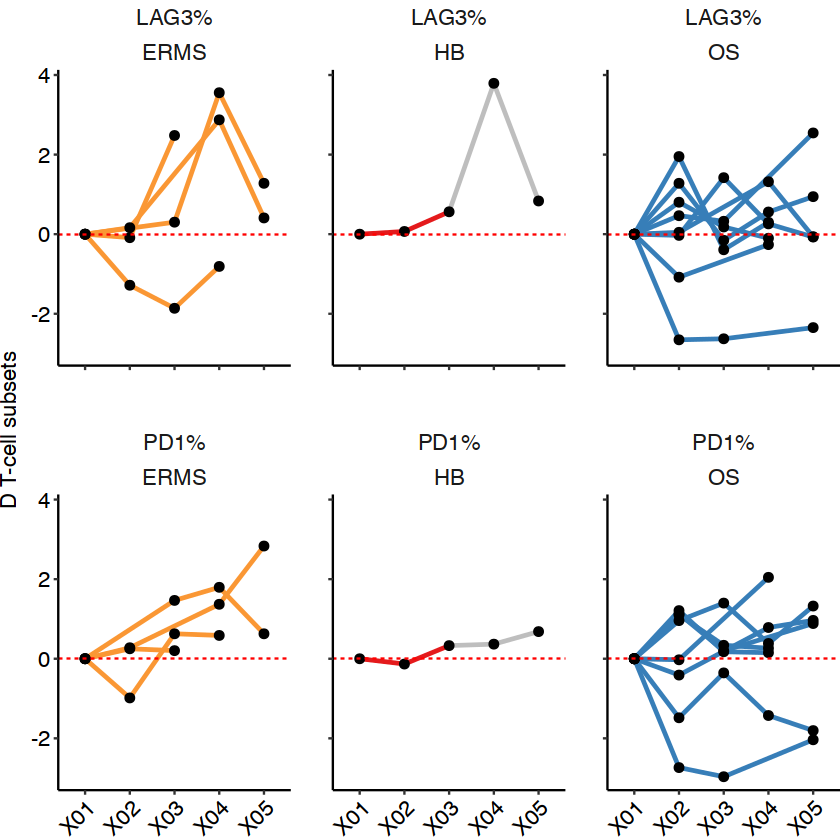

In [129]:
p_s_ic

In [130]:
pdf(paste0(plotpath, "p_HB_ERMS_OS_PD1_LAG3.pdf"), width = 6, height = 6)
cowplot::plot_grid(p_s_ic, labels = "E")
dev.off()

pdf 
  2